#  CNN Midi Drum Classifier

## Requirements
Have to be run in a python 3.11 env

In [89]:
#importing packages
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import os
import subprocess

# Picking out genres from dataset

Same code as in drumclassifier.

In [90]:

base_dir = './data'

# Define the genres you are interested in
genres = ['latin',  'jazz',  'punk', 'afrobeat', 'hiphop', 'soul', 'funk', 'rock', 'country', 'reggae']
# genres = ['jazz', 'rock']


# Function to check if the file genre is one of the target genres
def is_target_genre(filename):
    for genre in genres:
        if genre.replace('_', '-') in filename.lower():
            return True
    return False

# Collect all MIDI files that match the target genres
target_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.mid') and is_target_genre(file):
            full_path = os.path.join(root, file)
            target_files.append(full_path)

print(f"Found {len(target_files)} files in target genres.")
print(target_files[:10])

# Didnt actually end up using this, but I am keeping to code for later maybe
# Writing the paths to a text file for record-keeping or further processing
# with open('filtered_midi_files.txt', 'w') as f:
#     for item in target_files:
#         f.write("%s\n" % item)




Found 1025 files in target genres.
['./data/drummer8/session2/12_funk_81_beat_4-4.mid', './data/drummer8/session2/25_latin_84_beat_4-4.mid', './data/drummer8/session2/2_funk_92_beat_4-4.mid', './data/drummer8/session2/40_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/33_rock_117_beat_4-4.mid', './data/drummer8/session2/30_afrobeat_98_beat_4-4.mid', './data/drummer8/session2/39_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/14_afrobeat_103_beat_4-4.mid', './data/drummer8/session2/17_afrobeat_85_beat_4-4.mid', './data/drummer8/session2/31_afrobeat_98_beat_4-4.mid']


# Preprocsessing midi data
Same code as in drumclassifier.ipynb

In [91]:
import mido

filepath_1 = target_files[100] 
print(filepath_1)
def process_drum_track_mido(filepath):
    # Loading the MIDI file
    mid = mido.MidiFile(filepath)
    
    for i, track in enumerate(mid.tracks):
        print(f"Track {i}: {track.name}")
        for msg in track:
            if not msg.is_meta and msg.type in ['note_on', 'note_off']:
                # Seems channel 9 i correct (dont think im missing anything here?)
                # The data set says control changes are set on channel 0, but i get no data here?
                if msg.channel == 9:
                    print(f"Time: {msg.time}, Note: {msg.note}, Velocity: {msg.velocity}, Type: {msg.type}")
                    
# Example usage
# process_drum_track_mido(filepath_1)


./data/drummer1/session3/5_jazz-linear_128_beat_4-4.mid


# Extract features
Same code as in drumclassifier.ipynb

In [92]:
import mido
import numpy as np

# This gets turned into 0,1,2,3...21 in the matrix (showed in Example Usage)
relevant_notes = [36, 38, 40, 37, 48, 50, 45, 47, 43, 58, 46, 26, 42, 22, 44, 49, 55, 57, 52, 51, 59, 53]
bins_per_beat = 4
bars = 2
beats_per_bar = 4
total_beats = bars * beats_per_bar
total_bins_per_segment = total_beats * bins_per_beat

def midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2):
    """
    Segment a MIDI file into multiple fixed-length segments.

    Args:
        filepath (str): Path to the MIDI file.
        bins_per_beat (int): Number of bins per beat for quantization.
        bars_per_segment (int): Number of bars to include in each segment.

    Returns:
        List of np.ndarray: A list of 2D numpy arrays, each representing a segment.
    """
    mid = mido.MidiFile(filepath)

    note_indices = {note: i for i, note in enumerate(relevant_notes)}

    segments = []
    # Calculate bins and ticks for segmentation
    beats_per_bar = 4
    total_beats_per_segment = bars_per_segment * beats_per_bar
    total_bins_per_segment = total_beats_per_segment * bins_per_beat
    ticks_per_bin = mid.ticks_per_beat // bins_per_beat

    current_segment_start_tick = 0
    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
    current_bin_index = 0

    for track in mid.tracks:
        current_tick = 0
        for msg in track:
            if not msg.is_meta:
                current_tick += msg.time
                while current_tick >= current_segment_start_tick + (ticks_per_bin * total_bins_per_segment):
                    # Finalize current segment and start a new one
                    segments.append(segment_feature_matrix)
                    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
                    current_segment_start_tick += ticks_per_bin * total_bins_per_segment
                    current_bin_index = 0

                if msg.type in ['note_on', 'note_off'] and msg.channel == 9 and msg.note in relevant_notes:
                    if current_tick >= current_segment_start_tick:
                        bin_index = (current_tick - current_segment_start_tick) // ticks_per_bin
                        if msg.type == 'note_on' and msg.velocity > 0:
                            matrix_index = note_indices[msg.note]
                            segment_feature_matrix[matrix_index, bin_index] = msg.velocity
    # Add the last segment if it contains any note-ons
    if np.any(segment_feature_matrix):
        segments.append(segment_feature_matrix)
    # print(segments[0])

    return segments


def extract_features_and_genre_from_filename(filepath):
    features = midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2)
    # Extract genre from the filename
    filename = os.path.basename(filepath)
    genre = None
    for g in genres:
        if g in filename.lower():
            genre = g
            break
    return features, genre





# Example Usage
Same code as in drumclassifier.ipynb

Extracted features for 25_latin_84_beat_4-4.mid with genre latin
Extracted 20 segments from 25_latin_84_beat_4-4.mid
Example of one kick segment of 2 bars: 
 [  0.   0.   0.  58.   0.   0.   0.   0.  52.   0.   0. 118.   0.   0.
  38.  60.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 127.]
Example of one snare segment of 2 bars: 
 [  0. 127.   0.  16. 111.   0. 127.  86.   0.   0.   0.   0.   0. 127.
   0.  66.   0. 127.   0.  29. 127.  70. 127.   0. 127.  23. 127.  79.
   0. 127.   0.   0.]
Example of one ride bell segment of 2 bars: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


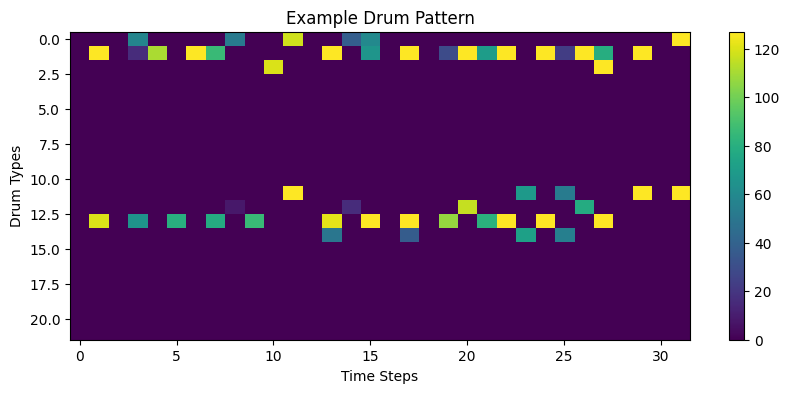

In [93]:


filepath_1 = target_files[1]
features, genre = extract_features_and_genre_from_filename(filepath_1)
print(f"Extracted features for {os.path.basename(filepath_1)} with genre {genre}")


segments = midi_file_to_segments(filepath_1)
print(f"Extracted {len(segments)} segments from {os.path.basename(filepath_1)}")
print("Example of one kick segment of 2 bars: \n",segments[1][0])
print("Example of one snare segment of 2 bars: \n",segments[1][1])
# Theres probably a lot of empty instruments like this one
print("Example of one ride bell segment of 2 bars: \n",segments[1][19])


def plot_drum_pattern(segment, title="Drum Pattern"):
    plt.figure(figsize=(10, 4))
    plt.imshow(segment, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Drum Types")
    plt.show()


if len(segments) > 0:
    plot_drum_pattern(segments[1].reshape(22, 32), title="Example Drum Pattern")


# CNN 
Using TensorFlow and Kera. 

Much of the same code as in drumclassifier, but in this notebook I have added a scaler and then a PCA filter to each timestep, taking a statistical analysis compared to the rest of the dataset. This filters the 22 dimensions down to 1 "eigenrythm", which is what the CNN model will be trained on. This way I keep the temporal patterns which i am interessted in exploring.

Create train/validation dataset

In [94]:
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


num_instruments = 22
num_timesteps = 32

X_list = []
y_list = []
for filepath in target_files:
    segments = midi_file_to_segments(filepath)
    _, genre = extract_features_and_genre_from_filename(filepath)
    if genre is not None:
        genre_index = genres.index(genre)
        for segment in segments:
            reshaped_segment = segment.reshape(num_instruments, num_timesteps)
            flattened_segment = reshaped_segment.flatten()
            X_list.append(flattened_segment)
            y_list.append(to_categorical(genre_index, len(genres)))

X = np.array(X_list)
y = np.array(y_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(-1, num_instruments, num_timesteps)


pca_list = []
for i in range(num_timesteps):
    pca = PCA(n_components=1)
    # Fit PCA on each timestep and save the model
    pca.fit(X_scaled[:, :, i])
    pca_list.append(pca)


# Transform data using each PCA model for further use or analysis
X_pca_transformed = [pca.transform(X_scaled[:, :, i]) for i, pca in enumerate(pca_list)]
X_pca = np.hstack(X_pca_transformed)

X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_train[0])


(8601, 32)
(2151, 32)
(8601, 10)
(2151, 10)
[-0.42942432 -0.40651965  0.1873818  -0.28483454 -0.28808019 -0.4309897
 -0.16693981 -0.24506809 -0.04142244 -0.07705408 -0.29937012  0.12675662
 -0.63701017 -0.21723517 -0.22307708 -0.70104747 -0.28277335 -0.4871161
  0.15836739  0.26765595 -0.39878326 -0.53036045 -0.12486829 -0.20466807
 -0.35142749 -0.15902144 -0.33207338  0.10956953 -0.57738696 -0.45311246
 -0.14968043 -0.97125521]


In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [96]:
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (X_train.shape[1], 1)  # (32, 1)
num_classes = len(genres)

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Summary of the model
model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])


Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_407 (Conv1D)         (None, 30, 32)            128       
                                                                 
 max_pooling1d_404 (MaxPool  (None, 15, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_408 (Conv1D)         (None, 13, 64)            6208      
                                                                 
 max_pooling1d_405 (MaxPool  (None, 6, 64)             0         
 ing1D)                                                          
                                                                 
 flatten_202 (Flatten)       (None, 384)               0         
                                                                 
 dropout_404 (Dropout)       (None, 384)            

# SAVE MODELS
Only uncomment if you wish to create a new model.
I recommend giving the new models new names so they do not override any other models. 
Is only necessary if you want to train on other genres, and if you do so, remember to update the genre list in ExtractMovementData so it matches!

In [97]:
import joblib


model.save('models/pca_cnn/pca_cnn_model_2G.keras') # Save the entire CNN model
joblib.dump(scaler, 'models/pca_cnn/scaler_2G.pkl')  # Save the scaler
joblib.dump(pca_list, 'models/pca_cnn/pca_list_2G.pkl')  # Save the list of PCA models


['models/pca_cnn/pca_list_2G.pkl']

# Analytic view on model

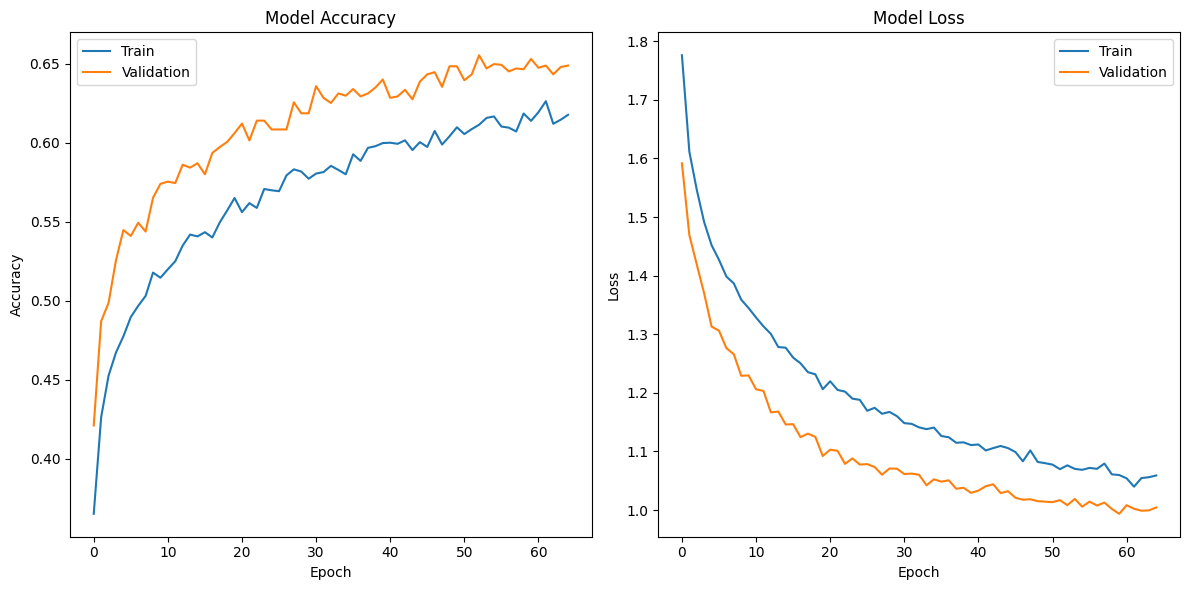

In [98]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


68/68 [==============================] - 0s 683us/step


/var/folders/kr/qv6lqld50753lntbp712rprm0000gn/T/ipykernel_8444/1292860778.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_labels)
/var/folders/kr/qv6lqld50753lntbp712rprm0000gn/T/ipykernel_8444/1292860778.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_labels)


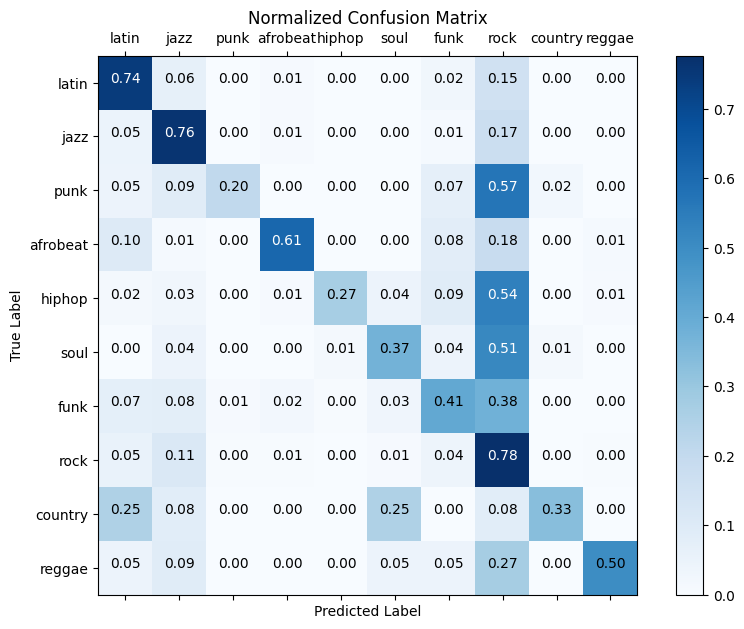

              precision    recall  f1-score   support

       latin       0.78      0.74      0.76       449
        jazz       0.62      0.76      0.68       316
        punk       0.60      0.20      0.31        44
    afrobeat       0.78      0.61      0.69        98
      hiphop       0.94      0.27      0.42       112
        soul       0.53      0.37      0.44        70
        funk       0.65      0.41      0.50       293
        rock       0.60      0.78      0.68       735
     country       0.57      0.33      0.42        12
      reggae       0.65      0.50      0.56        22

    accuracy                           0.65      2151
   macro avg       0.67      0.50      0.55      2151
weighted avg       0.67      0.65      0.64      2151



In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predicting the validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalizing the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(cm_normalized, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)


class_labels = genres 
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)

# Major ticks location
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

# Labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')

# Add annotations to cells
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.show()

# print a classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


# CNN Input
Help to visualize how the data looks after PCA analysis, and what the CNN gets trained on.

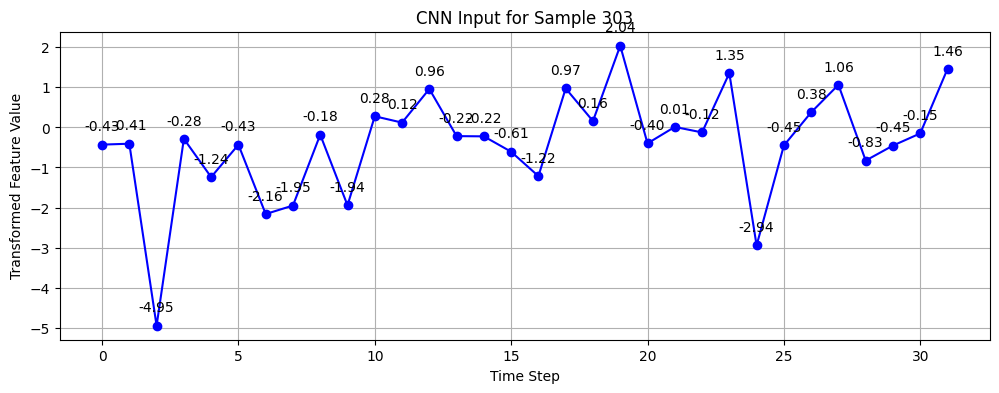

In [100]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cnn_input(X_transformed, sample_index=0):
    """
    Visualizes the transformed features for a single sample across its timesteps.
    Args:
    X_transformed (numpy.ndarray): The dataset with transformed features ready for CNN input.
    sample_index (int): Index of the sample in the dataset to visualize.
    """
    # Ensure correct dimensionality for visualization
    if X_transformed.ndim == 4 and X_transformed.shape[-1] == 1:
        # If it's 4D with the last dimension being 1, squeeze out the last dimension
        single_sample = X_transformed[sample_index, :, :, 0].flatten()
    elif X_transformed.ndim == 3 and X_transformed.shape[-1] == 1:
        # If it's 3D with the last dimension being 1, squeeze out the last dimension
        single_sample = X_transformed[sample_index, :, 0].flatten()
    elif X_transformed.ndim == 2:
        # If it's 2D, directly use it
        single_sample = X_transformed[sample_index, :].flatten()
    else:
        raise ValueError(f"Unexpected number of dimensions ({X_transformed.ndim}) in input array.")

    # Create a figure and a single subplot
    plt.figure(figsize=(12, 4))
    plt.plot(single_sample, marker='o', linestyle='-', color='b')
    plt.title(f'CNN Input for Sample {sample_index}')
    plt.xlabel('Time Step')
    plt.ylabel('Transformed Feature Value')
    plt.grid(True)
    
    # annotations to each point for clearer visibility of changes
    for i, value in enumerate(single_sample):
        plt.annotate(f"{value:.2f}",  
                     (i, value),
                     textcoords="offset points",
                     xytext=(0,10),  
                     ha='center')  

    plt.show()

# Example usage
sample_index = 303  # Example index, change as to whatever file you want (as long as its range of the target_files variable)
visualize_cnn_input(X_train, sample_index)



In [101]:
from sklearn.model_selection import RepeatedKFold



X = np.array(X_list)
y = np.array(y_list)

num_splits = 10
num_repeats = 5
rkf = RepeatedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)

fold_no = 1
all_scores = []

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA on each timestep
    X_train_pca_list = []
    X_test_pca_list = []
    for i in range(num_timesteps):
        pca = PCA(n_components=1)
        pca.fit(X_train_scaled[:, i*num_instruments:(i+1)*num_instruments])

        X_train_pca = pca.transform(X_train_scaled[:, i*num_instruments:(i+1)*num_instruments])
        X_test_pca = pca.transform(X_test_scaled[:, i*num_instruments:(i+1)*num_instruments])
        
        X_train_pca_list.append(X_train_pca)
        X_test_pca_list.append(X_test_pca)

    X_train_pca = np.hstack(X_train_pca_list)
    X_test_pca = np.hstack(X_test_pca_list)
    X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
    X_test_pca = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

    # Define and compile the model
    model = create_cnn_model((X_train_pca.shape[1], 1), len(genres))

    # Train the model
    history = model.fit(X_train_pca, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_test_pca, y_test))

    # Evaluate the model
    scores = model.evaluate(X_test_pca, y_test, verbose=0)
    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    all_scores.append(scores)
    fold_no += 1

# Calculate and print the mean and the standard deviation of the scores across folds
mean_scores = np.mean(all_scores, axis=0)
std_scores = np.std(all_scores, axis=0)
print(f'Mean scores across all folds: {mean_scores}')
print(f'Standard deviation across all folds: {std_scores}')


Score for fold 1: Loss of 0.9509667754173279; Accuracy of 64.40520286560059%
Score for fold 2: Loss of 0.9161983132362366; Accuracy of 66.7286217212677%
Score for fold 3: Loss of 1.0036791563034058; Accuracy of 65.3953492641449%
Score for fold 4: Loss of 0.9902058839797974; Accuracy of 65.67441821098328%
Score for fold 5: Loss of 0.966639518737793; Accuracy of 66.04651212692261%
Score for fold 6: Loss of 0.9448317885398865; Accuracy of 66.32558107376099%
Score for fold 7: Loss of 0.9355716705322266; Accuracy of 68.18604469299316%
Score for fold 8: Loss of 0.9729278683662415; Accuracy of 66.04651212692261%
Score for fold 9: Loss of 0.995927631855011; Accuracy of 64.2790675163269%
Score for fold 10: Loss of 0.9787994027137756; Accuracy of 65.58139324188232%
Score for fold 11: Loss of 0.9570244550704956; Accuracy of 63.94051909446716%
Score for fold 12: Loss of 0.9508066773414612; Accuracy of 66.0780668258667%
Score for fold 13: Loss of 0.9637008309364319; Accuracy of 66.69767498970032%
S